Part 2: Predicting precision: straight sum, linearly trained, specifically trained.

Setup:

In [16]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from scipy.stats import poisson
import matplotlib.patches as mpatches
from functools import partial
import os
import pickle
import demixing as dm
from demixing import MLP, HiddenLayer

nneuron = 61
min_angle = -90
max_angle = 90
sprefs = np.linspace(min_angle, max_angle, nneuron)
eps = np.finfo(np.float64).eps
sigtc_sq = float(10**2)

Train network:

In [2]:
nns = {}
for i in range(400):
    file_name = 'output_nn_tests_2/nn_tests_2_' + str(i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        nn, nnx, valid_mse, _, _ = pickle.load(pkl_file)
        nns[i] = (nn, nnx, valid_mse)

In [3]:
posts = {}
testsets = {}
for s_i in range(31):
    file_name = 'output_post_2/post_2_' + str(s_i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        p, r, c, delta_s = pickle.load(pkl_file)
        posts[delta_s] = p
        testsets[delta_s] = r

In [117]:
pkl_file = open('readout.pkl', 'wb')
pickle.dump((posts, testsets), pkl_file)
pkl_file.close()

In [122]:
pkl_file = open('output_nn_tests_3/nn_tests_3_26.pkl', 'rb')
nn, nnx, valid_mse, _, _ = pickle.load(pkl_file)

Readout of posterior:

In [123]:
#nn, nnx, valid_mse = nns[43]
x = []
y = []
for s_i in range(31):
    x.append(dm.get_hu_responses(testsets[s_i], nn))
    y.append(np.array((1/posts[s_i]['var_s1'], 1/posts[s_i]['var_s2'])))
y = np.concatenate(y, axis=1).T
x = np.concatenate(x)
inds = range(len(x))
np.random.shuffle(inds)
x_shuf = x[inds]
y_shuf = y[inds]
validset = x_shuf[0:2000], y_shuf[0:2000]
trainset = x_shuf[2000:], y_shuf[2000:]

In [130]:
validset

(array([[-0.        , -0.        ,  0.58952831, ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        ,  0.62491814, ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        ,  0.63755302, ..., -0.        ,
          0.66833988, -0.        ],
        ..., 
        [-0.        , -0.        ,  0.6766087 , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        ,  1.0503874 , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        ,  0.84296128, ..., -0.        ,
         -0.        , -0.        ]]), array([[ 0.03403592,  0.07384185],
        [ 0.09046695,  0.11373661],
        [ 0.04126395,  0.05159744],
        ..., 
        [ 0.09367429,  0.07359554],
        [ 0.07150746,  0.1602534 ],
        [ 0.05226268,  0.0715196 ]]))

In [124]:
nn_post, nnx_post, valid_mse_post = dm.train_nn(trainset, valid_dataset=validset, n_in=20, learning_rate=0.0001, n_epochs=100, linear=True, rho=.9, mu=.99, nesterov=True)

In [129]:
valid_mse_post

array([ 0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02186841,
        0.02186841,  0.02186841,  0.02186841,  0.02186841,  0.02

[[  1.  nan]
 [ nan  nan]]


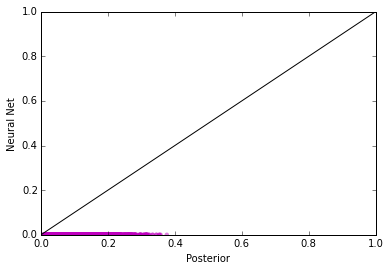

In [125]:
hus, vpost = validset
nn_posts1 = dm.get_hu_responses(hus, nn_post)
vp = np.concatenate((vpost.T[0], vpost.T[1]))
np1 = np.concatenate((nn_posts1.T[0], nn_posts1.T[1]))
plt.scatter(vp, np1, c='m', alpha=.5, edgecolor="None")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Posterior")
plt.ylabel("Neural Net")
plt.plot(range(2), c='k')
print np.corrcoef(vp, np1)

[[ 1.         -0.09850753]
 [-0.09850753  1.        ]]


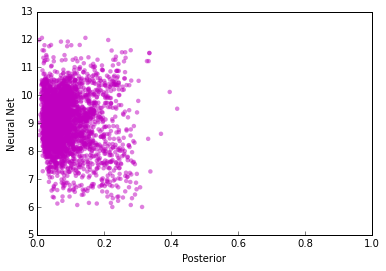

In [104]:
hus, vpost = validset
nn_posts1 = np.sum(hus, axis=1)
vp = np.concatenate((vpost.T[0], vpost.T[1]))
np1 = np.concatenate((nn_posts1, nn_posts1))
plt.scatter(vp, np1, c='m', alpha=.5, edgecolor="None")
#plt.scatter(vp[1], nn_posts1)
plt.xlim(0, 1)
plt.xlabel("Posterior")
plt.ylabel("Neural Net")
ax = plt.axes()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print np.corrcoef(vp, np1)

In [118]:
x = []
y = []
for s_i in range(31):
    x.append(testsets[s_i])
    y.append(np.array((1/posts[s_i]['var_s1'], 1/posts[s_i]['var_s2'])))
y = np.concatenate(y, axis=1).T
x = np.concatenate(x)
x_shuf = x[inds]
validset2 = x_shuf[0:2000], y_shuf[0:2000]
trainset2 = x_shuf[2000:], y_shuf[2000:]

In [111]:
nn_post2, nnx_post2, valid_mse_post2 = dm.train_nn(trainset2, valid_dataset=validset2, learning_rate=0.0001, mult_ys=False, n_epochs=100, rho=.9, mu=.99, nesterov=True)

[[ 1.          0.91955554]
 [ 0.91955554  1.        ]]


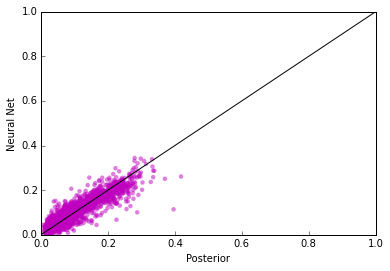

In [112]:
_, vpost2 = validset2
nn_posts2, _ = dm.test_nn(nn_post2, nnx_post2, validset2)
vp = np.concatenate((vpost2.T[0], vpost2.T[1]))
np2 = np.concatenate((nn_posts2.T[0], nn_posts2.T[1]))
plt.scatter(vp, np2, c='m', alpha=.5, edgecolor="None")
plt.xlim(0, 1)
plt.xlabel("Posterior")
plt.ylabel("Neural Net")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(range(2), c='k')
ax = plt.axes()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print np.corrcoef(vp, np2)